This notebook is based on Intro to DeepCell notebook. It works on tensorflow 2.7.1.<br>
It trains a model with three heads: inner distance, outer distance, and fgbg.


In [1]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

import deepcell
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell import image_generators

print(tf.__version__)

2.7.1


In [2]:
base_url = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
            'demos/janelia/hela_s3_{}_256.npz')

nuclear = deepcell.datasets.Dataset(
    path='nuclear.npz',
    url=base_url.format('nuclear'),
     file_hash=None,
    metadata=None
)

fluo_cyto = deepcell.datasets.Dataset(
    path='fluo_cyto.npz',
    url=base_url.format('fluo_cyto'),
     file_hash=None,
    metadata=None
)

phase = deepcell.datasets.Dataset(
    path='phase.npz',
    url=base_url.format('phase'),
     file_hash=None,
    metadata=None
)

In [3]:
dataset = nuclear  # nuclear, phase, fluo_cyto
model_name = 'nuclear_deep_watershed'

min_objects = 2

test_size = 0.2 # fraction of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = dataset.load_data(
    test_size=test_size, seed=seed)

print('X_train.shape: {}\nX_test.shape: {}'.format(
    X_train.shape, X_test.shape))
transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()

batch_size = 8

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

X_train.shape: (1728, 256, 256, 1)
X_test.shape: (432, 256, 256, 1)


(1728, 256, 256, 1)


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


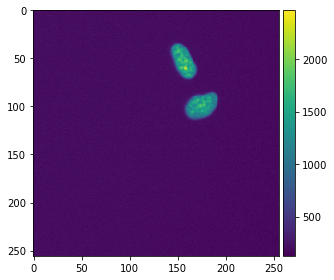

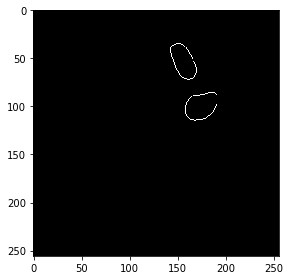

In [4]:
print(y_train.shape)

i=5

io.imshow(X_train[i,:,:,0])
plt.show()
#print(X_train[i,:,:,0])

tmp = syotil.masks_to_outlines(y_train[i,:,:,0])
io.imshow(tmp)
plt.show()

In [6]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

[('semantic_0', (None, 256, 256, 1)),
 ('semantic_1', (None, 256, 256, 1)),
 ('semantic_2', (None, 256, 256, 2))]

In [7]:
# fit the model

model_path = '{}.h5'.format(model_name)

print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=50,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 3 GPUs.


2022-10-29 10:22:23.071568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-10-29 10:22:23.072723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-10-29 10:22:23.073870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/50


2022-10-29 10:22:43.804198: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


204/204 [==============================] - ETA: 0s - loss: 0.0181 - semantic_0_loss: 0.0024 - semantic_1_loss: 0.0141 - semantic_2_loss: 0.0017
Epoch 00001: val_loss improved from inf to 0.01017, saving model to nuclear_deep_watershed.h5


/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


204/204 [==============================] - 94s 282ms/step - loss: 0.0181 - semantic_0_loss: 0.0024 - semantic_1_loss: 0.0141 - semantic_2_loss: 0.0017 - val_loss: 0.0102 - val_semantic_0_loss: 0.0016 - val_semantic_1_loss: 0.0052 - val_semantic_2_loss: 0.0033 - lr: 1.0000e-04
Epoch 2/50
204/204 [==============================] - ETA: 0s - loss: 0.0013 - semantic_0_loss: 4.5359e-04 - semantic_1_loss: 5.2964e-04 - semantic_2_loss: 3.3149e-04
Epoch 00002: val_loss improved from 0.01017 to 0.00360, saving model to nuclear_deep_watershed.h5
204/204 [==============================] - 54s 265ms/step - loss: 0.0013 - semantic_0_loss: 4.5359e-04 - semantic_1_loss: 5.2964e-04 - semantic_2_loss: 3.3149e-04 - val_loss: 0.0036 - val_semantic_0_loss: 6.5104e-04 - val_semantic_1_loss: 0.0018 - val_semantic_2_loss: 0.0012 - lr: 9.9000e-05
Epoch 3/50
204/204 [==============================] - ETA: 0s - loss: 0.0010 - semantic_0_loss: 3.6018e-04 - semantic_1_loss: 3.9375e-04 - semantic_2_loss: 2.5136e-0

204/204 [==============================] - ETA: 0s - loss: 5.9512e-04 - semantic_0_loss: 2.2519e-04 - semantic_1_loss: 2.0580e-04 - semantic_2_loss: 1.6412e-04
Epoch 00016: val_loss did not improve from 0.00070
204/204 [==============================] - 51s 251ms/step - loss: 5.9512e-04 - semantic_0_loss: 2.2519e-04 - semantic_1_loss: 2.0580e-04 - semantic_2_loss: 1.6412e-04 - val_loss: 7.0526e-04 - val_semantic_0_loss: 3.1145e-04 - val_semantic_1_loss: 2.5443e-04 - val_semantic_2_loss: 1.3938e-04 - lr: 8.6006e-05
Epoch 17/50
204/204 [==============================] - ETA: 0s - loss: 5.5401e-04 - semantic_0_loss: 2.1334e-04 - semantic_1_loss: 1.8421e-04 - semantic_2_loss: 1.5646e-04
Epoch 00017: val_loss did not improve from 0.00070
204/204 [==============================] - 51s 249ms/step - loss: 5.5401e-04 - semantic_0_loss: 2.1334e-04 - semantic_1_loss: 1.8421e-04 - semantic_2_loss: 1.5646e-04 - val_loss: 7.1087e-04 - val_semantic_0_loss: 3.1607e-04 - val_semantic_1_loss: 2.5255e-04

204/204 [==============================] - ETA: 0s - loss: 4.7371e-04 - semantic_0_loss: 1.7310e-04 - semantic_1_loss: 1.5606e-04 - semantic_2_loss: 1.4455e-04
Epoch 00031: val_loss did not improve from 0.00064
204/204 [==============================] - 51s 250ms/step - loss: 4.7371e-04 - semantic_0_loss: 1.7310e-04 - semantic_1_loss: 1.5606e-04 - semantic_2_loss: 1.4455e-04 - val_loss: 6.5044e-04 - val_semantic_0_loss: 3.1008e-04 - val_semantic_1_loss: 2.1837e-04 - val_semantic_2_loss: 1.2200e-04 - lr: 7.3970e-05
Epoch 32/50
204/204 [==============================] - ETA: 0s - loss: 4.5329e-04 - semantic_0_loss: 1.6790e-04 - semantic_1_loss: 1.4552e-04 - semantic_2_loss: 1.3987e-04
Epoch 00032: val_loss improved from 0.00064 to 0.00063, saving model to nuclear_deep_watershed.h5
204/204 [==============================] - 55s 267ms/step - loss: 4.5329e-04 - semantic_0_loss: 1.6790e-04 - semantic_1_loss: 1.4552e-04 - semantic_2_loss: 1.3987e-04 - val_loss: 6.2738e-04 - val_semantic_0_los

204/204 [==============================] - ETA: 0s - loss: 3.9636e-04 - semantic_0_loss: 1.3490e-04 - semantic_1_loss: 1.2884e-04 - semantic_2_loss: 1.3262e-04
Epoch 00046: val_loss improved from 0.00062 to 0.00062, saving model to nuclear_deep_watershed.h5
204/204 [==============================] - 54s 266ms/step - loss: 3.9636e-04 - semantic_0_loss: 1.3490e-04 - semantic_1_loss: 1.2884e-04 - semantic_2_loss: 1.3262e-04 - val_loss: 6.1793e-04 - val_semantic_0_loss: 2.9422e-04 - val_semantic_1_loss: 2.0574e-04 - val_semantic_2_loss: 1.1797e-04 - lr: 6.3619e-05
Epoch 47/50
204/204 [==============================] - ETA: 0s - loss: 3.9707e-04 - semantic_0_loss: 1.3470e-04 - semantic_1_loss: 1.3038e-04 - semantic_2_loss: 1.3198e-04
Epoch 00047: val_loss did not improve from 0.00062
204/204 [==============================] - 51s 249ms/step - loss: 3.9707e-04 - semantic_0_loss: 1.3470e-04 - semantic_1_loss: 1.3038e-04 - semantic_2_loss: 1.3198e-04 - val_loss: 6.7261e-04 - val_semantic_0_los

In [8]:
# create prediction model


prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape=X_test.shape[1:]
)

prediction_model.load_weights(model_path, by_name=True)

In [9]:
# make predictions on testing data

start = default_timer()
test_images = prediction_model.predict(X_test)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape,
      'in', watershed_time, 'seconds.')


masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)


Watershed segmentation of shape (432, 256, 256, 1) in 3.2643851339817047 seconds.


/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


In [10]:
X_test.shape

(432, 256, 256, 1)

In [ ]:
y_test[1,:,:,0]

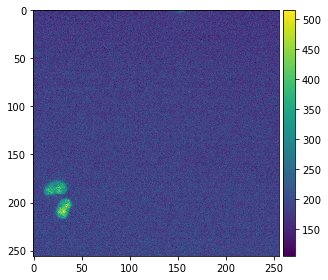

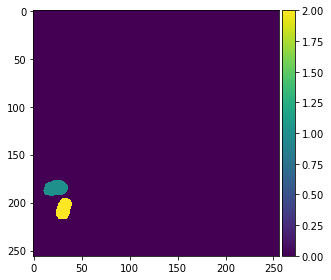

1.0

In [11]:
io.imshow(X_test[1,:,:,0])
plt.show()
io.imshow(y_test[1,:,:,0])
plt.show()
syotil.csi(y_test[1,:,:,0], masks[1,:,:,0])

In [12]:
# read CD3 data

img=io.imread("images/square_patches/M872956_JML_Position8_CD3_img_patch256x256.png")
print(img.shape)
X_cd3=img[:,:,2]
#io.imshow(im)
#plt.show()
X_cd3=np.expand_dims(X_cd3, -1) 
X_cd3=np.expand_dims(X_cd3, 0) 

y_cd3=io.imread("images/square_patches/M872956_JML_Position8_CD3_masks_patch256x256.png")
print(y_cd3.shape)
#io.imshow(mask_true)
#plt.show()
y_cd3=np.expand_dims(y_cd3, -1) 
y_cd3=np.expand_dims(y_cd3, 0) 

batch_size_cd3 = 1

print(X_cd3.shape)
print(y_cd3.shape)

train_cd3 = datagen.flow(
    {'X': X_cd3, 'y': y_cd3},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_cd3 = datagen_val.flow(
    {'X': X_cd3, 'y': y_cd3},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

(256, 256, 3)
(256, 256)
(1, 256, 256, 1)
(1, 256, 256, 1)


In [13]:
# make predictions on CD3 data
start = default_timer()
test_images = prediction_model.predict(X_cd3)
watershed_time = default_timer() - start

pred_cd3 = deep_watershed(
    test_images,
    min_distance=0,
    detection_threshold=0.001,
    distance_threshold=0.0,
    exclude_border=False,
    small_objects_threshold=0)

(1, 256, 256, 1) (1, 256, 256, 1)


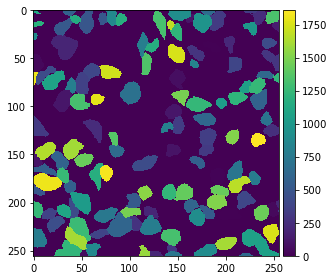

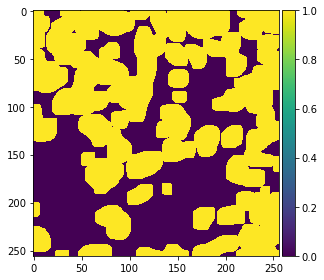

0.0

In [14]:
print(y_cd3.shape, pred_cd3.shape)
io.imshow(y_cd3[0,:,:,0])
plt.show()
io.imshow(pred_cd3[0,:,:,0])
plt.show()
syotil.csi(y_cd3[0,:,:,0], pred_cd3[0,:,:,0])
# the cyto_fluo training data cells are bigger than CD3 cells

In [15]:
# fit again with K data

loss_history = model.fit(
    train_cd3,
    steps_per_epoch=train_cd3.y.shape[0] // batch_size_cd3,
    epochs=100,
    validation_data=val_cd3,
    validation_steps=val_cd3.y.shape[0] // batch_size_cd3,
    callbacks=train_callbacks)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1366 - semantic_0_loss: 0.0433 - semantic_1_loss: 0.0689 - semantic_2_loss: 0.0244
Epoch 00001: val_loss did not improve from 0.00059
1/1 [==============================] - 1s 1s/step - loss: 0.1366 - semantic_0_loss: 0.0433 - semantic_1_loss: 0.0689 - semantic_2_loss: 0.0244 - val_loss: 0.0955 - val_semantic_0_loss: 0.0348 - val_semantic_1_loss: 0.0537 - val_semantic_2_loss: 0.0070 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1134 - semantic_0_loss: 0.0319 - semantic_1_loss: 0.0626 - semantic_2_loss: 0.0189
Epoch 00002: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 260ms/step - loss: 0.1134 - semantic_0_loss: 0.0319 - semantic_1_loss: 0.0626 - semantic_2_loss: 0.0189 - val_loss: 0.0955 - val_semantic_0_loss: 0.0348 - val_semantic_1_loss: 0.0539 - val_semantic_2_loss: 0.0068 - lr: 9.9000e-05
Epoch 3/100
1/1 [==============================] - ET

1/1 [==============================] - ETA: 0s - loss: 0.0642 - semantic_0_loss: 0.0246 - semantic_1_loss: 0.0339 - semantic_2_loss: 0.0057
Epoch 00018: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 277ms/step - loss: 0.0642 - semantic_0_loss: 0.0246 - semantic_1_loss: 0.0339 - semantic_2_loss: 0.0057 - val_loss: 0.0502 - val_semantic_0_loss: 0.0202 - val_semantic_1_loss: 0.0248 - val_semantic_2_loss: 0.0052 - lr: 8.4294e-05
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.0541 - semantic_0_loss: 0.0201 - semantic_1_loss: 0.0285 - semantic_2_loss: 0.0056
Epoch 00019: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 270ms/step - loss: 0.0541 - semantic_0_loss: 0.0201 - semantic_1_loss: 0.0285 - semantic_2_loss: 0.0056 - val_loss: 0.0493 - val_semantic_0_loss: 0.0197 - val_semantic_1_loss: 0.0245 - val_semantic_2_loss: 0.0051 - lr: 8.3451e-05
Epoch 20/100
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - ETA: 0s - loss: 0.0369 - semantic_0_loss: 0.0155 - semantic_1_loss: 0.0181 - semantic_2_loss: 0.0033
Epoch 00035: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 262ms/step - loss: 0.0369 - semantic_0_loss: 0.0155 - semantic_1_loss: 0.0181 - semantic_2_loss: 0.0033 - val_loss: 0.0428 - val_semantic_0_loss: 0.0162 - val_semantic_1_loss: 0.0222 - val_semantic_2_loss: 0.0044 - lr: 7.1055e-05
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0551 - semantic_0_loss: 0.0208 - semantic_1_loss: 0.0305 - semantic_2_loss: 0.0038
Epoch 00036: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 274ms/step - loss: 0.0551 - semantic_0_loss: 0.0208 - semantic_1_loss: 0.0305 - semantic_2_loss: 0.0038 - val_loss: 0.0430 - val_semantic_0_loss: 0.0163 - val_semantic_1_loss: 0.0223 - val_semantic_2_loss: 0.0044 - lr: 7.0345e-05
Epoch 37/100
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - ETA: 0s - loss: 0.0357 - semantic_0_loss: 0.0130 - semantic_1_loss: 0.0193 - semantic_2_loss: 0.0035
Epoch 00052: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 273ms/step - loss: 0.0357 - semantic_0_loss: 0.0130 - semantic_1_loss: 0.0193 - semantic_2_loss: 0.0035 - val_loss: 0.0418 - val_semantic_0_loss: 0.0159 - val_semantic_1_loss: 0.0218 - val_semantic_2_loss: 0.0042 - lr: 5.9896e-05
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.1692 - semantic_0_loss: 0.0480 - semantic_1_loss: 0.1180 - semantic_2_loss: 0.0032
Epoch 00053: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 273ms/step - loss: 0.1692 - semantic_0_loss: 0.0480 - semantic_1_loss: 0.1180 - semantic_2_loss: 0.0032 - val_loss: 0.0422 - val_semantic_0_loss: 0.0160 - val_semantic_1_loss: 0.0221 - val_semantic_2_loss: 0.0042 - lr: 5.9297e-05
Epoch 54/100
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - ETA: 0s - loss: 0.0434 - semantic_0_loss: 0.0173 - semantic_1_loss: 0.0231 - semantic_2_loss: 0.0029
Epoch 00069: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 264ms/step - loss: 0.0434 - semantic_0_loss: 0.0173 - semantic_1_loss: 0.0231 - semantic_2_loss: 0.0029 - val_loss: 0.0399 - val_semantic_0_loss: 0.0149 - val_semantic_1_loss: 0.0213 - val_semantic_2_loss: 0.0038 - lr: 5.0489e-05
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0474 - semantic_0_loss: 0.0188 - semantic_1_loss: 0.0255 - semantic_2_loss: 0.0030
Epoch 00070: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 271ms/step - loss: 0.0474 - semantic_0_loss: 0.0188 - semantic_1_loss: 0.0255 - semantic_2_loss: 0.0030 - val_loss: 0.0399 - val_semantic_0_loss: 0.0148 - val_semantic_1_loss: 0.0214 - val_semantic_2_loss: 0.0037 - lr: 4.9984e-05
Epoch 71/100
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - ETA: 0s - loss: 0.0298 - semantic_0_loss: 0.0123 - semantic_1_loss: 0.0155 - semantic_2_loss: 0.0021
Epoch 00086: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 269ms/step - loss: 0.0298 - semantic_0_loss: 0.0123 - semantic_1_loss: 0.0155 - semantic_2_loss: 0.0021 - val_loss: 0.0419 - val_semantic_0_loss: 0.0157 - val_semantic_1_loss: 0.0229 - val_semantic_2_loss: 0.0032 - lr: 4.2559e-05
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0716 - semantic_0_loss: 0.0257 - semantic_1_loss: 0.0427 - semantic_2_loss: 0.0032
Epoch 00087: val_loss did not improve from 0.00059
1/1 [==============================] - 0s 269ms/step - loss: 0.0716 - semantic_0_loss: 0.0257 - semantic_1_loss: 0.0427 - semantic_2_loss: 0.0032 - val_loss: 0.0419 - val_semantic_0_loss: 0.0158 - val_semantic_1_loss: 0.0229 - val_semantic_2_loss: 0.0032 - lr: 4.2133e-05
Epoch 88/100
1/1 [==============================] - ETA: 0s -